In [1]:
import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from twitter.models import *
import parliament.models as pms

from django.db.models import Sum, Count
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import datetime

import igraph
#import mpld3

from adjustText import adjust_text

print(igraph.__version__)

0.7.1


In [2]:
def draw_network(ax, g, layout, labels, interactive=False):
    #label_ids = [l['id'] for l in labels]
    x = [x[0] for x in layout]
    y = [x[1] for x in layout]
    c = [v["color"] for v in g.vs if v["color"] is not None]
    
    s = [12 + v["tweets"]*0.15 for v in g.vs]
    lw = [0.1 for v in g.vs ]

    scatter = ax.scatter(x,y,c=c,s=s,edgecolor="black",linewidths=lw)
    

    for e in g.es:#[:1000]:
        s = layout[e.source]
        t = layout[e.target]
        ex = [s[0],t[0]]
        ey = [s[1],t[1]]
        lw = 0.05+(np.log(e['weight']+1)*0.5) #+0.05+(np.log(e['connection_to_n']+1)*5)  #+0.05+np.log(e['connection_to_n'])
        alpha = 0.25
        ax.plot(
            ex,
            ey,
            c="grey",
            lw=lw,
            alpha=alpha,
            zorder=-5
        )    

    texts = []
    for l in labels:
        xy = layout[l["id"]]
        texts.append(ax.text(xy[0],xy[1],l["name"],fontsize=8))

    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    for text in texts:
        text.set_alpha(0.7)
        
    ax.grid(False)
    ax.axis('off')
    
    if interactive:
        tooltip =  mpld3.plugins.PointLabelTooltip(
            scatter, 
            labels=[x for x in g.vs["twitter-name"] if x is not None]
        )
        return tooltip

In [3]:
min_tweets = 2

t = "#Klimaschutzgesetz"
t = "#CO2Steuer"
s = TwitterSearch.objects.get(string=t)
tweets = s.status_set.all()

user_counts = tweets.values('author').annotate(
    n = Count('pk')
)

user_counts.filter(n__gt=min_tweets).count()

3187

In [4]:

user_rts = tweets.filter(
    retweeted_by__isnull=False,
).values('author','retweeted_by').annotate(
    n = Count('pk')
)
print(f"retweeted tweets: {user_rts.count()}")
user_rts.order_by('-n')

from collections import ChainMap
tweeters = set(user_rts.values_list('author',flat=True))
retweeters = set(user_rts.values_list('retweeted_by',flat=True))
print(f"{len(tweeters)} tweeters")
print(f"{len(retweeters)} retweeters")
user_ids = tweeters | retweeters
id_map = [{uid: i} for i,uid in enumerate(user_ids)]
id_map = dict(ChainMap(*id_map))
g = igraph.Graph()
g.add_vertices(len(user_ids))

retweeted tweets: 17593
1289 tweeters
9274 retweeters


In [5]:
tuids = list(tweets.filter(retweeted_by__isnull=False).values_list('author__id',flat=True))
colours = [None] * len(user_ids)
tweet_n = [None] * len(user_ids)
names = [None] * len(user_ids)

for uid, i in id_map.items():
    u = User.objects.get(pk=uid)
    names[i] = u.name
    tweet_n[i] = len([t for t in tuids if t==uid])
    if u.person:
        colours[i] = u.person.party.colour
    else:
        colours[i] = "#d3d3d3"
        
g.vs["twitter-name"] = names
g.vs["color"] = colours
g.vs["tweets"] = tweet_n


weights = []
edges = []
for ur in user_rts:
    if ur['author'] in id_map and ur['retweeted_by'] in id_map:
        edges.append((id_map[ur['author']],id_map[ur['retweeted_by']]))
        weights.append(ur['n'])

g.add_edges(edges)
g.es['weight'] = weights

print(g.summary())


IGRAPH U-W- 10032 17593 -- 
+ attr: color (v), tweets (v), twitter-name (v), weight (e)


In [6]:
g = g.clusters().giant()

ig_layout = g.layout("fr")

labels = []
for i, d in enumerate(g.degree()):
    if d > 5:
        labels.append({
            "id": i,
            "name": g.vs["twitter-name"][i],
            "d": d 
        })
        
labels = sorted(labels, key=lambda k: k['d'], reverse=True)
labels


[{'d': 697, 'id': 1399, 'name': 'Sergei 3000'},
 {'d': 425, 'id': 703, 'name': 'Markus Roscher-Meinel 🇩🇪'},
 {'d': 413, 'id': 1783, 'name': 'Stefan Slaby'},
 {'d': 402, 'id': 6529, 'name': 'Volker Quaschning'},
 {'d': 368, 'id': 5133, 'name': 'Richard Feuerbach'},
 {'d': 323, 'id': 326, 'name': 'Harald Laatsch MdA'},
 {'d': 320, 'id': 5135, 'name': 'Jörg Spengler'},
 {'d': 315, 'id': 8320, 'name': 'clas hannes'},
 {'d': 311, 'id': 7995, 'name': 'Edgar Allan Poe™'},
 {'d': 294, 'id': 1486, 'name': 'Don Alphonso'},
 {'d': 283, 'id': 5322, 'name': 'Andreas Hallaschka'},
 {'d': 234, 'id': 8310, 'name': 'Ruprecht Polenz'},
 {'d': 231, 'id': 2294, 'name': 'Prof. Dr. Jörg Meuthen'},
 {'d': 229, 'id': 6248, 'name': 'Marina Weisband'},
 {'d': 228, 'id': 3448, 'name': 'Emma Richter'},
 {'d': 226, 'id': 5660, 'name': 'braves Bürgerlein ©'},
 {'d': 226, 'id': 6957, 'name': 'Ali Utlu'},
 {'d': 214, 'id': 7630, 'name': 'Stefan Krauter'},
 {'d': 208, 'id': 3045, 'name': 'Fernschreiber'},
 {'d': 198, 

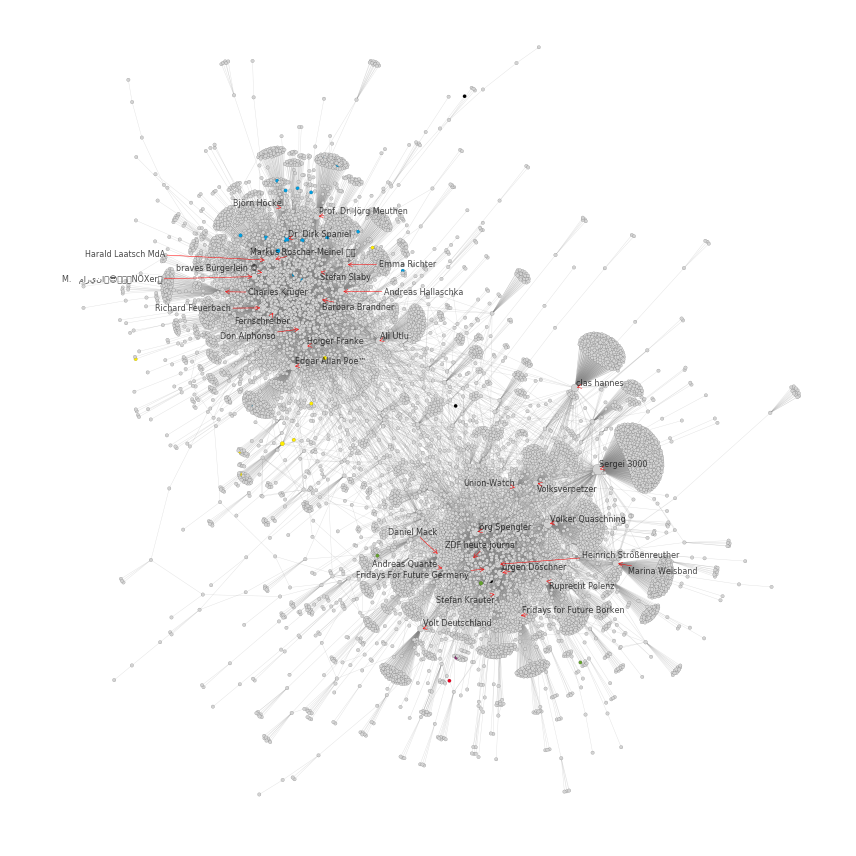

In [7]:
fig, ax = plt.subplots(figsize=(12,12))

draw_network(ax, g, ig_layout, labels[:35])

fig.tight_layout()

plt.savefig(f'plots/rt_network_{s.string}.png', bbox_inches="tight")


plt.show()

In [8]:
for t in tweets.filter(author__name="Sergei 3000"):
    print()
    print(t.retweets_count)
    print(t.text)


697
Wer sitzt bei Dorothee Bär als Berater?

Frank Thelen!

Wer hat Beteiligungen an einem #Flugtaxis Startup?

Frank Thelen!

Was will die #cdu statt #CO2Steuer?

Frank Thelen!
